# ALL ZIPCODE PLOTS

In [69]:
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import pacmap
import numpy as np
import re
import json
import csv
import matplotlib.pyplot as plt


In [70]:
# model=word2vec.Word2Vec.load('../Data/Models/word2vec_epoch_1000_min_1.model')
#model=word2vec.Word2Vec.load('../Data/Models/best_model.model')
model=word2vec.Word2Vec.load('../Data/Models/best_model_new.model') #dim 300 mange gange med adressesammensmeltning
#model=word2vec.Word2Vec.load('../Data/Models/model_5325_locations_50e.model') #dim 300 mange gange med adressesammensmeltning
#model=word2vec.Word2Vec.load('../Data/Models/best_model_100_dim_5e.model')

In [71]:
f = open('../Data/data.json')
data = json.load(f)

a = open('../Data/added_data.json')
added_data = json.load(a)

In [72]:
with open('../Data/sequences.csv', 'r') as f:
    reader = csv.reader(f)
    sequences = list(reader)

In [73]:
X = model.wv.vectors

In [74]:
# tsne
def tsne_plot(X):
    X=np.array(X)
    #pca = PCA(n_components=50)
    #X_pca=pca.fit_transform(X)
    proj = TSNE(perplexity=20).fit_transform(X)
    return proj
proj=tsne_plot(X)

# UMAP 
proj_1 = umap.UMAP(n_components=2, n_neighbors=20, metric='cosine').fit_transform(X)

# pca 
pca = PCA(n_components=2)
proj_2=pca.fit_transform(X)

In [75]:
# pacmap 
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_3 = embedding.fit_transform(X, init="pca")


In [76]:
# Create a dictionary to map addresses to their corresponding embeddings
journey_embeddings = {}
for journey in sequences:
    for location in journey:
        try:
            journey_embeddings[location] = model.wv[location]
        except KeyError:
            # Handle cases where the journey is not present in the Word2Vec model
            pass

# Convert dictionary to numpy array
X = np.array(list(journey_embeddings.values()))

# Create a list of all addresses
journey_ids = list(journey_embeddings.keys())

# Create a dictionary mapping addresses to their index in the numpy array
journey_idx = {journey_id: idx for idx, journey_id in enumerate(journey_ids)}

In [77]:
# print(len(journey_ids)) #number of unique locations is 3751

In [78]:
def getZip(info):
    pattern_zip = '\d{4}'
    pattern_denmark = 'anmark'
    match_zip = re.search(pattern_zip, info)
    match_denmark = re.search(pattern_denmark, info)
    if match_zip is not None and match_denmark is not None:
        return match_zip.group()
    else :
        return
    

In [79]:
pattern = r'\d.*'

def get_modified (location):
    location = (re.sub(pattern, '', location)).strip()
    if location == '':
        return
    if location[-1] == '(':
        location = location[:-1]
    if location == 'Zoo':
        location = "Zoologisk Have"
    return location


In [80]:
address_cluster_zips = {}
zip_to_label = {'1000': 'Kbh K', '1700': 'Vesterbro', '2000': 'Frederiksberg', '2100': 'Østerbro', '2200': 'Nørrebro', 
                '2300': 'Kbh S', '2400': 'Kbh NV', '2500': 'Valby', '2600': 'Glostrup', '2700': 'Brønshøj', '2800': 'Lyngby', '2900': 'Hellerup', '2770': 'Kastrup'}
zip_to_label_clustered = {'2800': 'Nord', '1000': 'Midt', '2600': 'Vest', '2300' : 'Syd'}
wrong_addresses = []

In [81]:

for address, info in data.items():
    if info is not None: 
        zip_code = getZip(info['address'])  # Extract zip code from address can be empty
        if zip_code is not None:
            zip = int(zip_code)
            if 1000 <= zip <= 4999: #for now removing all failed zipcodes in Jylland
                if 1000 <= zip <= 1499:
                    #Kbh K
                    address_cluster_zips[address] = '1000'
                elif 1500 <= zip <= 1799:
                    #Kbh V
                    address_cluster_zips[address] = '1700'
                elif zip == 2000:
                    #Frederiksberg C
                    address_cluster_zips[address] = '2000'
                elif 2000 < zip < 2200: #2150 er Nordhavn
                    #Østerbro
                    address_cluster_zips[address] = '2100'
                elif 2200 <= zip < 2300:
                    #København N (Nørrebro)
                    address_cluster_zips[address] = '2200'
                elif 2300 <= zip < 2400:
                    #Amager Kbh S
                    address_cluster_zips[address] = '2300'
                elif 2400 <= zip < 2500:
                    #Kbh NV
                    address_cluster_zips[address] = '2400'
                elif 2500 <= zip < 2600:
                    #Valby
                    address_cluster_zips[address] = '2500'
                elif 2600 <= zip < 2700:
                    #Glostrup
                    address_cluster_zips[address] = '2600'
                elif zip == 2770 or zip == 2791:
                    #Kastrup Dragør
                    address_cluster_zips[address] = '2770'
                elif 2700 <= zip < 2800:
                    #Brønshøj
                    address_cluster_zips[address] = '2700'
                elif 2800 <= zip < 2900:
                    #Lyngby
                    address_cluster_zips[address] = '2800'
                elif 2800 <= zip < 2900:
                    #Hellerup
                    address_cluster_zips[address] = '2900'
            else: 
                wrong_addresses.append(address) #go through later


#run through the list of wrong addresses and try to find them in the added_data.json file to get the "correct" zipcode
for address in wrong_addresses:
    #find in json file
    if address in added_data:
        zip_code = getZip(added_data[address]['address'])
        if zip_code is not None:
            zip = int(zip_code)
            if 1000 <= zip <= 4999: #for now removing all failed zipcodes in Jylland
                if 1000 <= zip <= 1499:
                    #Kbh K
                    address_cluster_zips[address] = '1000'
                elif 1500 <= zip <= 1799:
                    #Kbh V
                    address_cluster_zips[address] = '1700'
                elif zip == 2000:
                    #Frederiksberg C
                    address_cluster_zips[address] = '2000'
                elif 2000 < zip < 2200: #2150 er Nordhavn
                    #Østerbro
                    address_cluster_zips[address] = '2100'
                elif 2200 <= zip < 2300:
                    #København N (Nørrebro)
                    address_cluster_zips[address] = '2200'
                elif 2300 <= zip < 2400:
                    #Amager Kbh S
                    address_cluster_zips[address] = '2300'
                elif 2400 <= zip < 2500:
                    #Kbh NV
                    address_cluster_zips[address] = '2400'
                elif 2500 <= zip < 2600:
                    #Valby
                    address_cluster_zips[address] = '2500'
                elif 2600 <= zip < 2700:
                    #Glostrup
                    address_cluster_zips[address] = '2600'
                elif zip == 2770 or zip == 2791:
                    #Kastrup Dragør
                    address_cluster_zips[address] = '2770'
                elif 2700 <= zip < 2800:
                    #Brønshøj
                    address_cluster_zips[address] = '2700'
                elif 2800 <= zip < 2900:
                    #Lyngby
                    address_cluster_zips[address] = '2800'
                elif 2800 <= zip < 2900:
                    #Hellerup
                    address_cluster_zips[address] = '2900'

In [82]:
from collections import Counter

# Count occurrences of each zip code
zip_code_counts = Counter(address_cluster_zips.values())

# Print the zip code counts
for zip_code, count in zip_code_counts.items():
    print(f"Zip code {zip_code}: {count} addresses")

Zip code 2100: 3345 addresses
Zip code 2400: 3539 addresses
Zip code 1000: 3995 addresses
Zip code 2300: 6497 addresses
Zip code 2500: 2205 addresses
Zip code 1700: 2522 addresses
Zip code 2770: 2999 addresses
Zip code 2800: 413 addresses
Zip code 2000: 1921 addresses
Zip code 2200: 2916 addresses
Zip code 2700: 2554 addresses
Zip code 2600: 797 addresses


In [83]:
# New dictionary to store modified keys and their corresponding zip codes
modified_new_address_cluster_zips = {}

# Iterate through the keys, apply regex operation, and update the new dictionary
for address, zipcode in address_cluster_zips.items():
    new_address = get_modified(address)
    modified_new_address_cluster_zips[new_address] = zipcode


{'2900': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), '2800': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), '2770': (1.0, 0.7333333333333333, 0.47058823529411764, 1.0), '2700': (0.596078431372549, 0.8745098039215686, 0.5411764705882353, 1.0), '2600': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), '2500': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0), '2400': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0), '2300': (0.7686274509803922, 0.611764705882353, 0.5803921568627451, 1.0), '2200': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058, 1.0), '2100': (0.7803921568627451, 0.7803921568627451, 0.7803921568627451, 1.0), '2000': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0), '1700': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0), '1000': (0.6196078431372549, 0.8549019607843137, 0.8980392156862745, 1.0)}


/var/folders/z3/0j97vknj4696wz9q6_jg32240000gn/T/ipykernel_1300/385688039.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab20', num_colors)  # Choose a colormap
/var/folders/z3/0j97vknj4696wz9q6_jg32240000gn/T/ipykernel_1300/385688039.py:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  col.scatter(


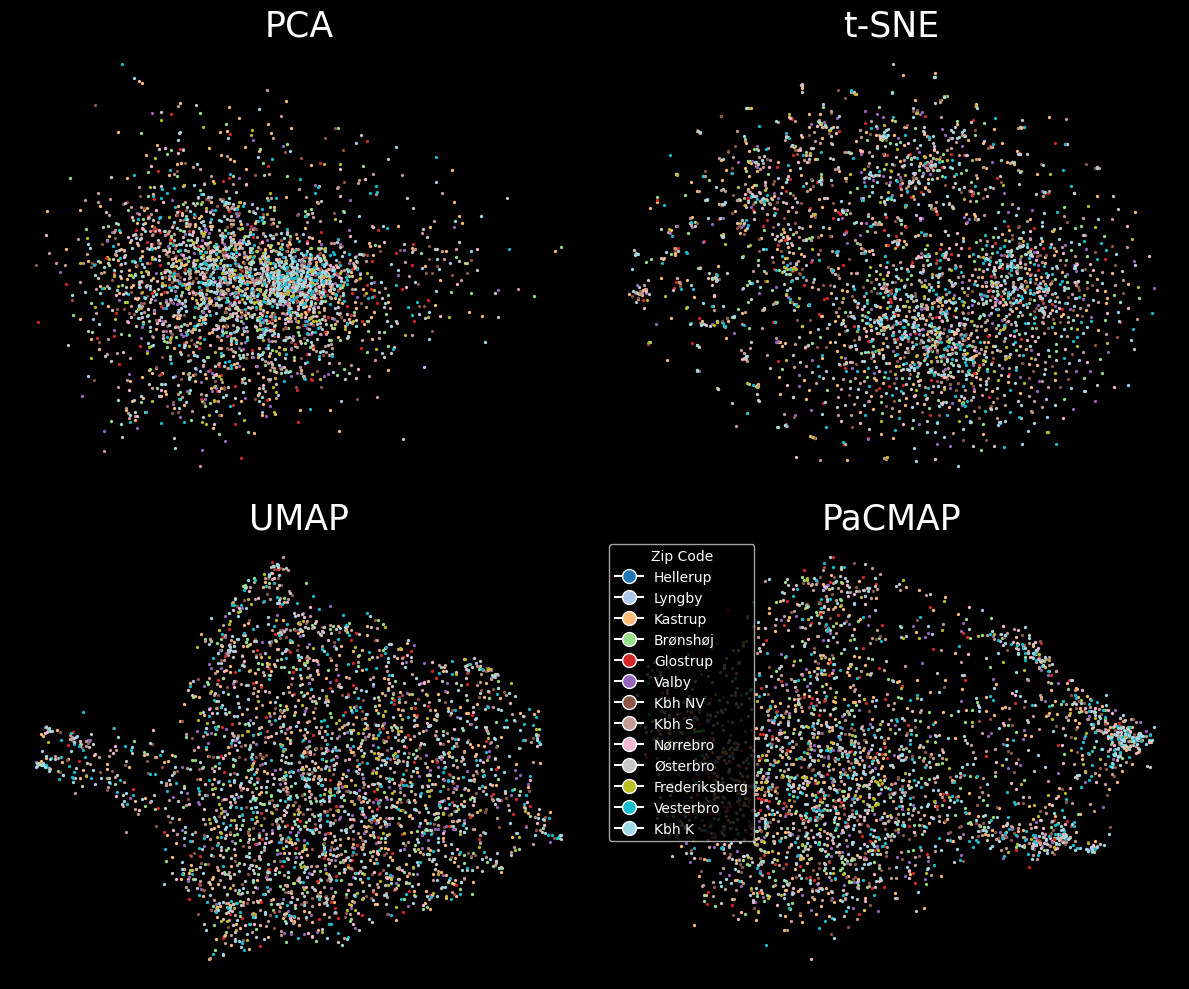

In [84]:

# Define color palette for zip codes
zip_colors = {}  # Dictionary to map zip codes to colors
unique_zip_codes = sorted(zip_to_label.keys(), reverse=True)
num_colors = len(unique_zip_codes) #change this
color_palette = plt.cm.get_cmap('tab20', num_colors)  # Choose a colormap
#print("number of unique zips: ", num_colors)

for idx, zip_code in enumerate(unique_zip_codes):
    zip_colors[zip_code] = color_palette(idx)

print(zip_colors)
# Create the plots
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
xs = [proj_2, proj, proj_1, proj_3]  # Use xs to select different dimensionality reduction results
ts = ["PCA", "t-SNE", "UMAP", "PaCMAP"]
s = 0

#should be two times two
for row in ax:
    for col in row:
        #print("One plot")
        col.set_title(ts[s], fontsize=25)
        # # Filter journeys by field

        for current_zip_code in unique_zip_codes:
            # Plot all journeys for each zip code
            relevant_addresses = []
            for address, zip_code in modified_new_address_cluster_zips.items():
                if address in journey_ids:
                    if current_zip_code == zip_code:
                        relevant_addresses.append(address)

            relevant_journeys_zip = [journey_id for journey_id in relevant_addresses]
            col.scatter(
                [xs[s][journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip],
                [xs[s][journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip],
                lw=0.1, s=5, label=current_zip_code, c=zip_colors[current_zip_code]
            )
        s += 1
        col.axis('off')

# Custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=zip_colors[zip_code], label=zip_to_label[zip_code]) for zip_code in unique_zip_codes]
plt.legend(handles=handles, title='Zip Code')

fig.tight_layout()
plt.show()


More clustered

In [85]:
#Nord, Midt, Vest, Syd
for address, info in data.items():
    if info is not None: 
        zip_code = getZip(info['address'])  # Extract zip code from address can be empty
        if zip_code is not None:
            zip = int(zip_code)
            if 1000 <= zip <= 4999: #for now removing all failed zipcodes in Jylland
                        if 1000 <= zip <= 1499:
                            #Kbh K
                            address_cluster_zips[address] = '1000'
                        elif 1500 <= zip <= 1799:
                            #Kbh V
                            address_cluster_zips[address] = '1000'
                        elif zip == 2000:
                            #Frederiksberg C
                            address_cluster_zips[address] = '1000'
                        elif 2000 < zip < 2200: #2150 er Nordhavn
                            #Østerbro
                            address_cluster_zips[address] = '1000'
                        elif 2200 <= zip < 2300:
                            #København N (Nørrebro)
                            address_cluster_zips[address] = '1000'
                        elif 2300 <= zip < 2400:
                            #Amager Kbh S
                            address_cluster_zips[address] = '2300'
                        elif 2400 <= zip < 2500:
                            #Kbh NV
                            address_cluster_zips[address] = '1000'
                        elif 2500 <= zip < 2600:
                            #Valby
                            address_cluster_zips[address] = '2300'
                        elif 2600 <= zip < 2700:
                            #Glostrup
                            address_cluster_zips[address] = '2600'
                        elif zip == 2770 or zip == 2791:
                            #Kastrup Dragør
                            address_cluster_zips[address] = '2300'
                        elif 2700 <= zip < 2800:
                            #Brønshøj
                            address_cluster_zips[address] = '1000'
                        elif 2800 <= zip < 2900:
                            #Lyngby
                            address_cluster_zips[address] = '2800'
                        elif 2800 <= zip < 2900:
                            #Hellerup
                            address_cluster_zips[address] = '2800'
            else: 
                wrong_addresses.append(address) #go through later


#run through the list of wrong addresses and try to find them in the added_data.json file to get the "correct" zipcode
for address in wrong_addresses:
    #find in json file
    if address in added_data:
        zip_code = getZip(added_data[address]['address'])
        if zip_code is not None:
            zip = int(zip_code)
            if 1000 <= zip <= 1499:
                #Kbh K
                address_cluster_zips[address] = '1000'
            elif 1500 <= zip <= 1799:
                #Kbh V
                address_cluster_zips[address] = '1000'
            elif zip == 2000:
                #Frederiksberg C
                address_cluster_zips[address] = '1000'
            elif 2000 < zip < 2200: #2150 er Nordhavn
                #Østerbro
                address_cluster_zips[address] = '1000'
            elif 2200 <= zip < 2300:
                #København N (Nørrebro)
                address_cluster_zips[address] = '1000'
            elif 2300 <= zip < 2400:
                #Amager Kbh S
                address_cluster_zips[address] = '2300'
            elif 2400 <= zip < 2500:
                #Kbh NV
                address_cluster_zips[address] = '1000'
            elif 2500 <= zip < 2600:
                #Valby
                address_cluster_zips[address] = '2300'
            elif 2600 <= zip < 2700:
                #Glostrup
                address_cluster_zips[address] = '2600'
            elif zip == 2770 or zip == 2791:
                #Kastrup Dragør
                address_cluster_zips[address] = '2300'
            elif 2700 <= zip < 2800:
                #Brønshøj
                address_cluster_zips[address] = '1000'
            elif 2800 <= zip < 2900:
                #Lyngby
                address_cluster_zips[address] = '2800'
            elif 2800 <= zip < 2900:
                #Hellerup
                address_cluster_zips[address] = '2800'

In [86]:
pattern = r'\d.*'

def get_modified (location):
    location = (re.sub(pattern, '', location)).strip()
    if location == '':
        return
    if location[-1] == '(':
        location = location[:-1]
    if location == 'Zoo':
        location = "Zoologisk Have"
    return location


In [87]:
# New dictionary to store modified keys and their corresponding zip codes
modified_address_cluster_zips = {}

# Iterate through the keys, apply regex operation, and update the new dictionary
for address, zipcode in address_cluster_zips.items():
    new_address = get_modified(address)
    modified_address_cluster_zips[new_address] = zipcode


{'2800': 'tab:blue', '2600': 'tab:orange', '2300': 'tab:green', '1000': 'tab:red'}
address found in data.json Otto Mallings Gade
address found in data.json Borgbjergsvej
address found in data.json Nørre Farimagsgade
address found in data.json Nyrnberggade
address found in data.json Dag Hammarskjölds Allé
address found in data.json Vigerslev Allé
address found in data.json Arkonagade
address found in data.json Lyongade
address found in data.json Bachersmindevej
address found in data.json Thingvalla Allé
address found in data.json Ungarnsgade
address found in data.json Maglestien
address found in data.json Bag Elefanterne
address found in data.json Alsgade
address found in data.json Tomsgårdsvej
address found in data.json Wilkensvej
address found in data.json Tåsingegade
address found in data.json Korsgade
address found in data.json Belfastvej
address not found in journeys_id Belfastvej
address found in data.json Alliancevej
address found in data.json Kyringevej
address not found in jour

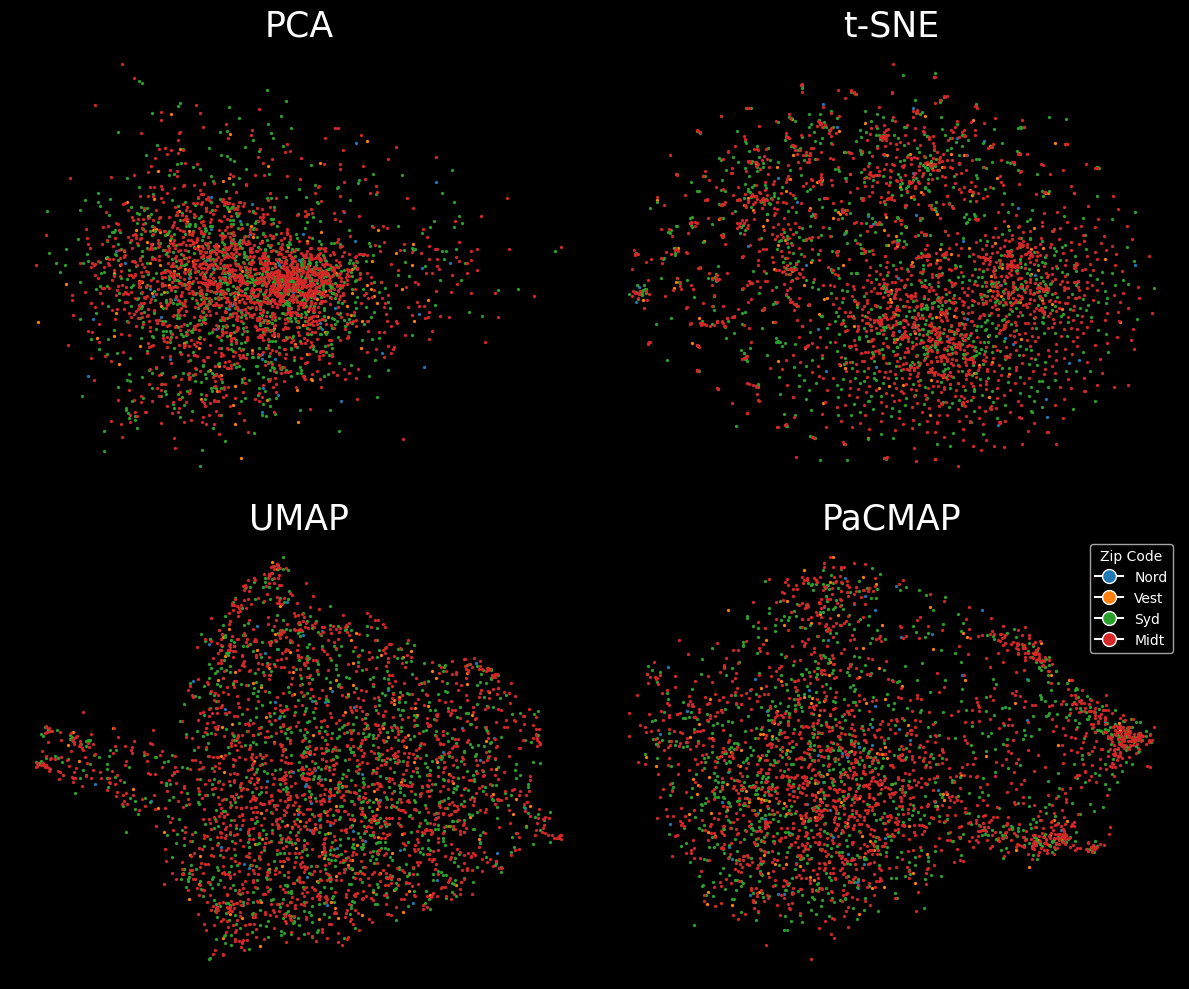

In [88]:

# Define color palette for zip codes
zip_colors = {}  # Dictionary to map zip codes to colors
unique_zip_codes = sorted(zip_to_label_clustered.keys(), reverse=True)
num_colors = len(unique_zip_codes) #change this
#color_palette = plt.cm.get_cmap('tab20', num_colors)  # Choose a colormap
color_palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
#print("number of unique zips: ", num_colors)

for idx, zip_code in enumerate(unique_zip_codes):
    zip_colors[zip_code] = color_palette[idx]

print(zip_colors)
# Create the plots
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
xs = [proj_2, proj, proj_1, proj_3]  # Use xs to select different dimensionality reduction results
ts = ["PCA", "t-SNE", "UMAP", "PaCMAP"]
s = 0
test_set = []
#should be two times two
for row in ax:
    for col in row:
        #print("One plot")
        col.set_title(ts[s], fontsize=25)
        # # Filter journeys by field

        for current_zip_code in unique_zip_codes:
            # Plot all journeys for each zip code
            relevant_addresses = []
            for address, zip_code in modified_address_cluster_zips.items():
                print("address found in data.json", address)
                if address in journey_ids:
                    if current_zip_code == zip_code:
                        test_set.append(address)
                        relevant_addresses.append(address)

                else : print("address not found in journeys_id", address)
            relevant_journeys_zip = [journey_id for journey_id in relevant_addresses]
            col.scatter(
                [xs[s][journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip],
                [xs[s][journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip],
                lw=0.1, s=5, label=current_zip_code, c=zip_colors[current_zip_code]
            )

        s += 1
        col.axis('off')

# Custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=zip_colors[zip_code], label=zip_to_label_clustered[zip_code]) for zip_code in unique_zip_codes]
plt.legend(handles=handles, title='Zip Code')

fig.tight_layout()
plt.show()


_______________________________________________________________________________________________________________________________________________

# Models

In [89]:
model_2000_300=word2vec.Word2Vec.load('../Data/Models/best_model_new.model') 
model_50_100=word2vec.Word2Vec.load('../Data/Models/model_5325_locations_50e_100d.model')
model_50_300=word2vec.Word2Vec.load('../Data/Models/model_5325_locations_50e_300d.model')
model_2000_100=word2vec.Word2Vec.load('../Data/Models/model_5325_locations_2000e.model')
model_10000_100_lowest=word2vec.Word2Vec.load('../Data/Models/model_10000e_100d_lowest_loss.model')
model_10000_100=word2vec.Word2Vec.load('../Data/Models/model_10000e_100d.model')

In [90]:
X = model_2000_300.wv.vectors
embedding_2000_300 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_2000_300 = embedding_2000_300.fit_transform(X, init="pca")

X1 = model_50_100.wv.vectors
embedding_50_100 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_50_100 = embedding_50_100.fit_transform(X1, init="pca")

X2 = model_50_300.wv.vectors
embedding_50_300 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_50_300 = embedding_50_300.fit_transform(X2, init="pca")

X3 = model_2000_100.wv.vectors
embedding_2000_100 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_2000_100 = embedding_2000_100.fit_transform(X3, init="pca")


X4 = model_10000_100_lowest.wv.vectors
embedding_10000_100_lowest = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_10000_100_lowest = embedding_10000_100_lowest.fit_transform(X4, init="pca")

X5 = model_10000_100.wv.vectors
embedding_10000_100 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_10000_100 = embedding_10000_100.fit_transform(X5, init="pca")


/var/folders/z3/0j97vknj4696wz9q6_jg32240000gn/T/ipykernel_1300/1525313346.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('YlOrRd', num_colors)  # Choose a colormap
/var/folders/z3/0j97vknj4696wz9q6_jg32240000gn/T/ipykernel_1300/1525313346.py:30: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  col.scatter(


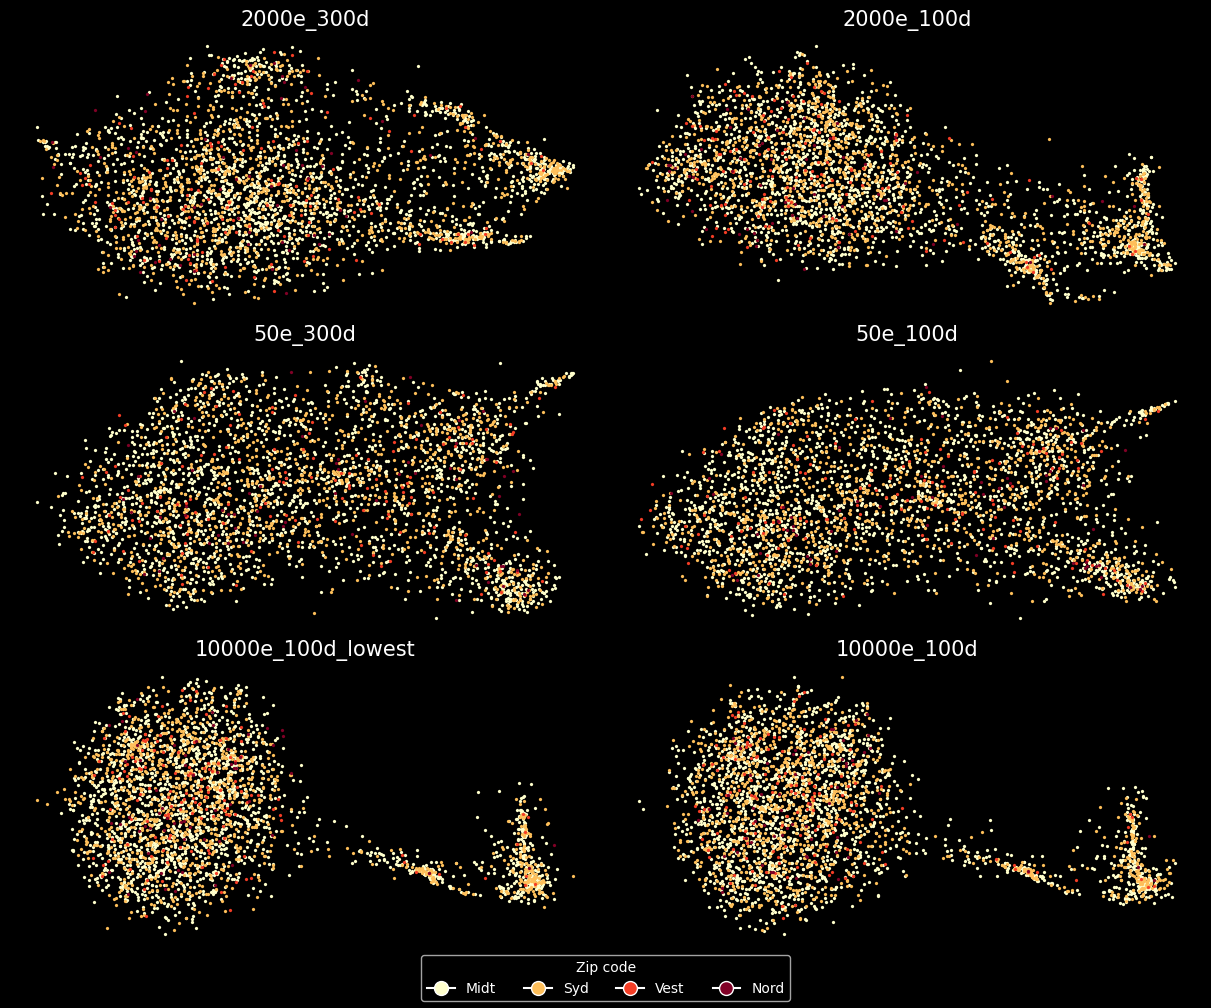

In [91]:

# Define color palette for zip codes
zip_colors = {}  # Dictionary to map zip codes to colors
unique_zip_codes = sorted(zip_to_label_clustered.keys(), reverse=False)
num_colors = len(unique_zip_codes) #change this
color_palette = plt.cm.get_cmap('YlOrRd', num_colors)  # Choose a colormap

for idx, zip_code in enumerate(unique_zip_codes):
    zip_colors[zip_code] = color_palette(idx)

# Create the plots
fig, ax = plt.subplots(3, 2, figsize=(12, 10), layout='constrained')
xs = [proj_2000_300, proj_2000_100, proj_50_300, proj_50_100, proj_10000_100_lowest, proj_10000_100]  # Use xs to select different dimensionality reduction results
ts = ["2000e_300d", "2000e_100d","50e_300d" , "50e_100d", "10000e_100d_lowest", "10000e_100d"]
s = 0

for row in ax:
    for col in row:
  
        col.set_title(ts[s], fontsize=15)

        for current_zip_code in unique_zip_codes:
            # Plot all journeys for each zip code
            relevant_addresses = []
            for address, zip_code in modified_address_cluster_zips.items():
                if address in journey_ids:
                    if current_zip_code == zip_code:
                        test_set.append(address)
                        relevant_addresses.append(address)
            relevant_journeys_zip = [journey_id for journey_id in relevant_addresses]
            col.scatter(
                [xs[s][journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip],
                [xs[s][journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip],
                lw=0.1, s=5, label=current_zip_code, c=zip_colors[current_zip_code]
            )

        s += 1
        col.axis('off')

# Custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=zip_colors[zip_code], label=zip_to_label_clustered[zip_code]) for zip_code in unique_zip_codes]
fig.legend(handles= handles, title='Zip code', loc="outside lower center", ncol=4)
plt.show()
